### Automatic determination of the central intensity of the solar disk 

The idea consists of, given a solar disk image and center position (in pixels), the code calculates the azimuthal averages of the solar disk intensity and fits the center to limb variation with a polynomial of order n, as in [D. Hestroffer and C. Magnan (1998)](http://articles.adsabs.harvard.edu/pdf/1998A%26A...333..338H), to determine the intensity at disk center. Usually, to properly fit the limb, the polynomial order should be equal or larger than two for a successful fit (except close to the limb) but, if the user restricts to values above $\mu = \cos{\theta} \ge 0.6$ a first order polynomial suffices. The fitting is done using the Newton method and can be written down analytically for first order polynomials.

Within this code, the limb position is determined by looking at the extrema of the azimuthally averaged intensity. In this sense, the user does not need to provide the solar disk radius or plate scale. In any other case (i.e., if this is not the desired option) the user should provide the solar disk radius in pixel units. 


In [1]:
import numpy as np
import matplotlib 
import matplotlib.pyplot as plt
font = {'size'   : 14}
matplotlib.rc('font', **font)
plt.rc('text', usetex=True)

**Step 1**: read solar data.

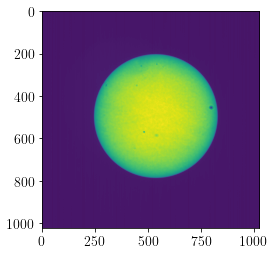

In [2]:
img = np.load('test_data.npy')
plt.imshow(img)

**Step 2**: calculate azimuthal averages using `azimutal_average()`. This program averages intensity data for different radius values with a *size_of_bin* step size (default 2).

The center of the test image is $[498, 535]$ and its radius $394.50$ (in pixel units). The user should provide, at least, the center.

In [3]:
def azimutal_average(img,centers,size_of_bin = 2):
  sy,sx = img.shape
  [X, Y] = np.meshgrid(np.arange(sx) - centers[0], np.arange(sy) - centers[1])
  R = np.sqrt(np.square(X) + np.square(Y))
  rad = np.arange(1, np.max(R), 1)
  intensity = np.zeros(len(rad))
  index = 0
  size_of_bin = 2
  for i in rad:
      mask = (np.greater(R, i - size_of_bin) & np.less(R, i + size_of_bin))
      values = img[mask]
      intensity[index] = np.mean(values)
      index += 1
  return intensity, rad

In [4]:
# here we perform the actual derivation:
intensity, rad = azimutal_average(img,[498,535])

**Step 3**: if the user knows the radius, the result should be limited between $r = [0,R_\odot]$. In any case it is derived here using the derivative (shift). Here it is important to determine $\mu$.

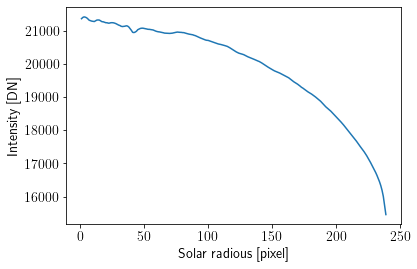

In [5]:
derivative = (np.roll(intensity,1) - intensity)
idx_max = np.where(derivative == np.max(derivative))
clv = intensity[0:int(idx_max[0])]
clv_r = rad[0:int(idx_max[0])]
mu = np.sqrt( (1 - clv_r**2/clv_r[-1]**2) )

plt.plot(clv_r,clv)
plt.xlabel('Solar radious [pixel]')
plt.ylabel('Intensity [DN]')
plt.show()

**Step 4**: fits the limb and determines the intensity at the disk center. I will put below a code for the n-order polynomials with an example. Here, I put the simplest case, i.e., order = 1.

Disk intensity:  21250.670677762235


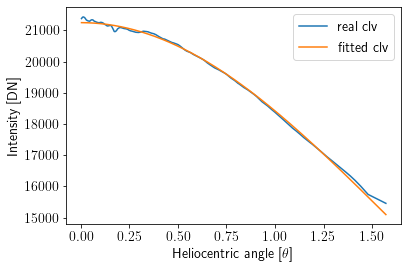

In [6]:
limit_to_disk_center_area = np.where(mu > 0.6)
#initial parameters for u and I0
#u is the coefficient for first order polinomial
u = 0.8
I0 = 30500

for i in range(2):  #two iterations is enough. Actually one almost ok.
  
  clv_naive = I0 * (1 - u * (1 - mu))  #CLV of first order (guess function)

  chi = (clv - clv_naive)              #merit function (without norma)
  dchi2_dI0 = - (1 - u * (1 - mu))       #derivative wrt I0
  dchi2_du  = - ( I0 * (mu - 1))         #derivative wrt u

  dr = np.transpose(np.array([dchi2_dI0,dchi2_du]))  # (x_par, x_data) -> (x_data, x_par) 

  J = np.matmul(chi,dr)                    #Jacobian  2-elements array
  H = np.matmul(np.transpose(dr),dr)       #Appx Hessian 2x2 matrix
  HI = np.linalg.inv(H)                    #Appx Hessian 2x2 matrix
  Delta = np.matmul(HI,np.transpose(J))    #inferred delta 2-elements array
  I0 -= Delta[0]                           #update params
  u  -= Delta[1]                           #update params

clv_naive = I0 * (1 - u * (1 - mu))        #final function
print("Disk intensity: ", I0)

ax = plt.gca()  
plt.plot(np.arccos(mu),clv,label='real clv')
plt.plot(np.arccos(mu),clv_naive,label='fitted clv')
plt.xlabel('Heliocentric angle ['+r'$\theta$]')
plt.ylabel('Intensity [DN]')
plt.legend()
plt.show()

### General case

[30500, 0.3]
[2.12649804e+04 2.96141510e-01]
[2.12649804e+04 2.96141510e-01]
[2.12649804e+04 2.94465834e-01]
[2.12649804e+04 2.94465834e-01]
[2.12649804e+04 2.94465834e-01]
[30500, 0.3, 0.2]
[2.12693347e+04 2.98440436e-01 5.62763342e-02]
[2.12693347e+04 2.98440436e-01 5.62763342e-02]
[ 2.12693347e+04  2.97763601e-01 -6.09820978e-03]
[ 2.12693347e+04  2.97763601e-01 -6.09820978e-03]
[ 2.12693347e+04  2.97763601e-01 -6.09820978e-03]
[2.12649804e+04 2.94465834e-01] [ 2.12693347e+04  2.97763601e-01 -6.09820978e-03]


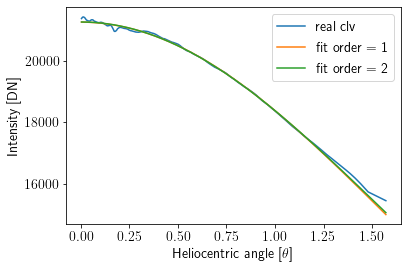

In [7]:
def limb_darkening(x,pars):
    ''' Limb darkening function and its derivative
    Returns the funcion and derivatives respect to pars 
       as numpy arrays of dimension (x_data, x_par) 
       x : mu = 1 - cos(theta)
       I = I0 * ( 1 - sum_(k=1)^(order) a_k * mu^k)
       Based on D. Hestroffer and C. Magnan, Astron. Astrophys. 333, 338–342 (1998)
    '''
    # Order 1 case (simplest)
    # df_dI0 = -(1 - u * (1 - mu))
    # df_du  = -( I0 * (mu - 1))

    order = len(pars)
    I0 = pars[0]
    mu = 1 - x
    exponent = np.arange(order-1, dtype=float) + 1.0
    
    fn = np.zeros((len(mu)))
    fn[:] = I0
    for i in exponent:
        fn[:] -= I0 * pars[int(i)] * mu**i
        
    dr = np.zeros((len(mu),len(pars)))
    dr[:,0] = 1
    for i in exponent:
        dr[:,0] -=  pars[int(i)] * mu**i
    for i in exponent:
        dr[:,int(i)] = - I0 * mu**i
    
    return fn , dr 
  
def newton(y,x,pars,func, **args):

  try:
    iter = int(iter)
  except:
    iter = 3
  for i in range(iter):
    
    fn , dr = func(x,pars,**args)

    chi2 = np.sum((y - fn)**2)
    chi = (y - fn)
    J = np.matmul(chi, - dr)
    H = np.matmul(np.transpose( - dr), - dr)
    HI = np.linalg.inv(H)
    Change = np.matmul(HI,np.transpose(J))
    pars_new = pars - Change

    print(pars)
    print(pars_new)
    pars = pars_new

  return pars
    
u = 0.3
I0 = 30500
ande = np.where(mu > 0.3)
pars2 = newton(clv[ande],mu[ande],[I0,u],limb_darkening)
pars3 = newton(clv[ande],mu[ande],[I0,u,0.2],limb_darkening)
print(pars2,pars3)

oldf, _ = limb_darkening(mu,[I0,u,0.2])
newf2, _ = limb_darkening(mu,pars2)
newf3, _ = limb_darkening(mu,pars3)
plt.plot(np.arccos(mu),clv,label='real clv')
plt.plot(np.arccos(mu),newf2,label='fit order = 1')
plt.plot(np.arccos(mu),newf3,label='fit order = 2')
plt.xlabel('Heliocentric angle ['+r'$\theta$]')
plt.ylabel('Intensity [DN]')
plt.legend()
